# Walmart Sales Forecasting 

## Problem Statement
A retail store with multiple outlets across the country is facing issues in managing inventory to match demand with supply. We need to analyze weekly sales data and forecast future sales.

## Objectives
1. Analyze if weekly sales are affected by unemployment rate
2. Identify seasonal trends in sales
3. Examine temperature's impact on sales
4. Study Consumer Price Index effects on sales
5. Identify top and worst performing stores
6. Forecast sales for next 12 weeks

## 1. Import Libraries and Load Data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


In [9]:
# Load the Walmart sales dataset
df = pd.read_csv('Walmart DataSet.csv')

# Basic sanity check: size, columns, and a quick preview
df.shape
df.columns
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## 2. Data Exploration and Cleaning

In [10]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
df.describe()

Missing Values:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Basic Statistics:


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [11]:
# Convert Date column and create time-based features for analysis
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

df[['Date']].agg(['min', 'max'])


,Date
min,2010-01-10
max,2012-12-10


## 3. Exploratory Data Analysis (EDA)

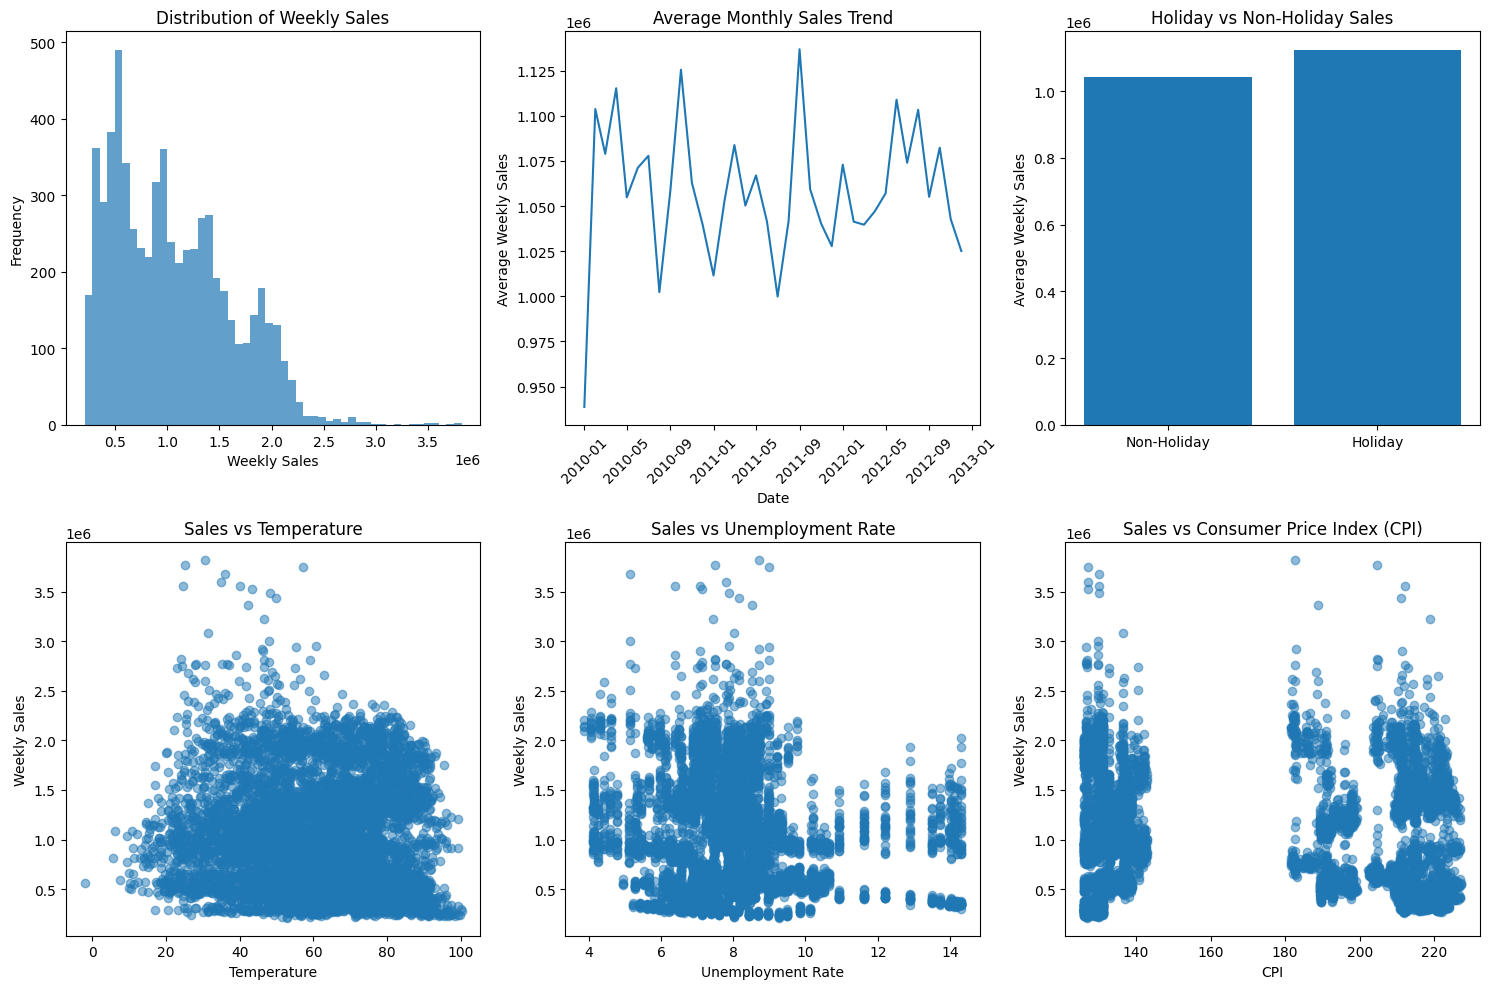

In [12]:
# -----------------------------
# Basic Exploratory Data Analysis
# -----------------------------
plt.figure(figsize=(15, 10))

# 1. Distribution of Weekly Sales
plt.subplot(2, 3, 1)
plt.hist(df['Weekly_Sales'], bins=50, alpha=0.7)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')


# 2. Average Monthly Sales Trend
plt.subplot(2, 3, 2)
monthly_sales = (
    df.groupby(['Year', 'Month'])['Weekly_Sales']
      .mean()
      .reset_index()
)
monthly_sales['Date'] = pd.to_datetime(
    monthly_sales[['Year', 'Month']].assign(day=1)
)

plt.plot(monthly_sales['Date'], monthly_sales['Weekly_Sales'])
plt.title('Average Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=45)


# 3. Holiday vs Non-Holiday Sales
plt.subplot(2, 3, 3)
holiday_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].mean()
plt.bar(['Non-Holiday', 'Holiday'], holiday_sales.values)
plt.title('Holiday vs Non-Holiday Sales')
plt.ylabel('Average Weekly Sales')


# 4. Relationship Between Temperature and Sales
plt.subplot(2, 3, 4)
plt.scatter(df['Temperature'], df['Weekly_Sales'], alpha=0.5)
plt.title('Sales vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')


# 5. Relationship Between Unemployment and Sales
plt.subplot(2, 3, 5)
plt.scatter(df['Unemployment'], df['Weekly_Sales'], alpha=0.5)
plt.title('Sales vs Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Weekly Sales')


# 6. Relationship Between CPI and Sales
plt.subplot(2, 3, 6)
plt.scatter(df['CPI'], df['Weekly_Sales'], alpha=0.5)
plt.title('Sales vs Consumer Price Index (CPI)')
plt.xlabel('CPI')
plt.ylabel('Weekly Sales')

plt.tight_layout()
plt.show()


## 4. Analysis Questions

### Question 1: Impact of Unemployment Rate on Sales

Correlation between Weekly Sales and Unemployment: -0.1062

Top 5 stores most affected by unemployment (negative correlation):
Store
38   -0.785290
44   -0.780076
39   -0.384681
42   -0.356355
41   -0.350630
dtype: float64


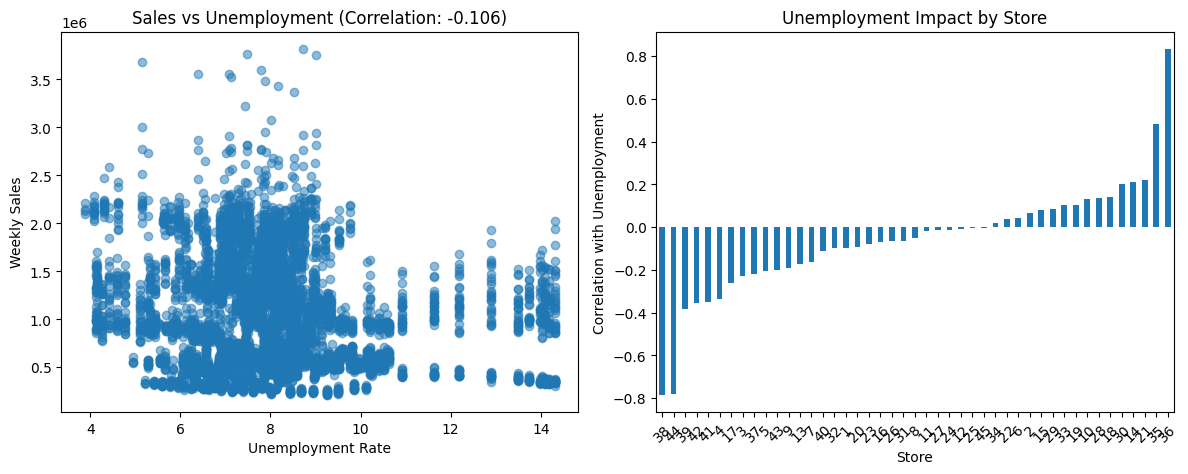

In [13]:
# Calculate correlation between unemployment and sales
correlation = df['Weekly_Sales'].corr(df['Unemployment'])
print(f"Correlation between Weekly Sales and Unemployment: {correlation:.4f}")

# Analyze by store
store_unemployment_impact = df.groupby('Store').apply(
    lambda x: x['Weekly_Sales'].corr(x['Unemployment'])
).sort_values()

print("\nTop 5 stores most affected by unemployment (negative correlation):")
print(store_unemployment_impact.head())

# Visualize
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['Unemployment'], df['Weekly_Sales'], alpha=0.5)
plt.xlabel('Unemployment Rate')
plt.ylabel('Weekly Sales')
plt.title(f'Sales vs Unemployment (Correlation: {correlation:.3f})')

plt.subplot(1, 2, 2)
store_unemployment_impact.plot(kind='bar')
plt.title('Unemployment Impact by Store')
plt.xlabel('Store')
plt.ylabel('Correlation with Unemployment')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Question 2: Seasonal Trends

Average Sales by Month:
Month 1.0: $1,008,661.31
Month 2.0: $1,070,975.69
Month 3.0: $1,064,207.94
Month 4.0: $1,062,675.56
Month 5.0: $1,057,716.88
Month 6.0: $1,087,900.96
Month 7.0: $1,037,893.22
Month 8.0: $1,047,227.09
Month 9.0: $1,089,198.44
Month 10.0: $1,095,038.94
Month 11.0: $1,045,289.61
Month 12.0: $1,034,510.93

Average Sales by Quarter:
Q1.0: $1,050,754.53
Q2.0: $1,069,431.14
Q3.0: $1,060,497.96
Q4.0: $1,058,279.83


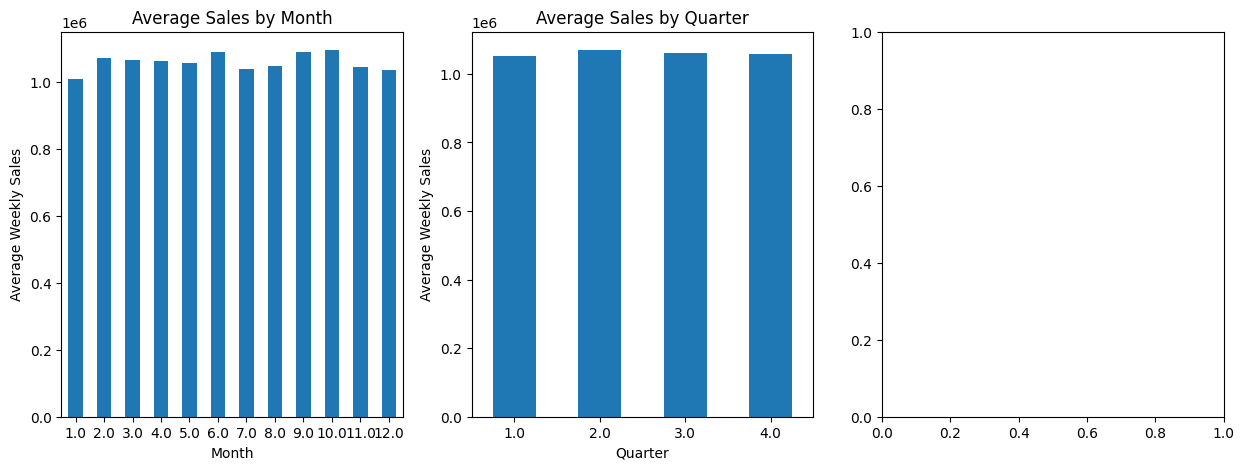

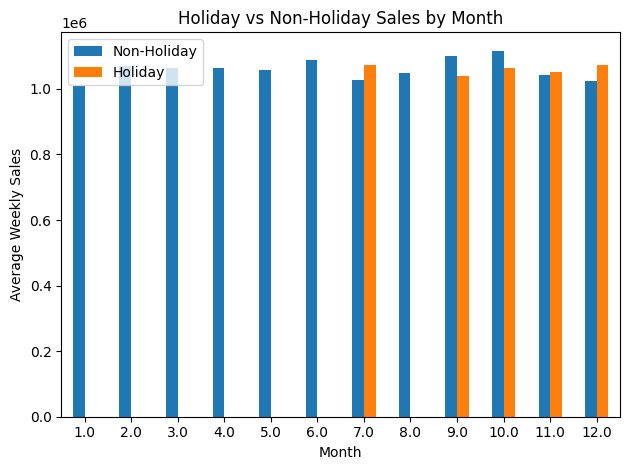


Peak sales month: 10.0 (likely holiday season)
Peak sales quarter: Q2.0


In [14]:
# Monthly sales trend
monthly_avg = df.groupby('Month')['Weekly_Sales'].mean()
quarterly_avg = df.groupby('Quarter')['Weekly_Sales'].mean()

print("Average Sales by Month:")
for month, sales in monthly_avg.items():
    print(f"Month {month}: ${sales:,.2f}")

print("\nAverage Sales by Quarter:")
for quarter, sales in quarterly_avg.items():
    print(f"Q{quarter}: ${sales:,.2f}")

# Visualize seasonal trends
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
monthly_avg.plot(kind='bar')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=0)

plt.subplot(1, 3, 2)
quarterly_avg.plot(kind='bar')
plt.title('Average Sales by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=0)

plt.subplot(1, 3, 3)
# Holiday vs non-holiday by month
holiday_monthly = df.groupby(['Month', 'Holiday_Flag'])['Weekly_Sales'].mean().unstack()
holiday_monthly.plot(kind='bar')
plt.title('Holiday vs Non-Holiday Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.legend(['Non-Holiday', 'Holiday'])
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Find peak season
peak_month = monthly_avg.idxmax()
peak_quarter = quarterly_avg.idxmax()
print(f"\nPeak sales month: {peak_month} (likely holiday season)")
print(f"Peak sales quarter: Q{peak_quarter}")

### Question 3: Temperature Impact on Sales

Correlation between Weekly Sales and Temperature: -0.0638

Average Sales by Temperature Category:
Cold: $924,875.97
Cool: $1,114,005.25
Warm: $1,047,908.89
Hot: $992,940.01


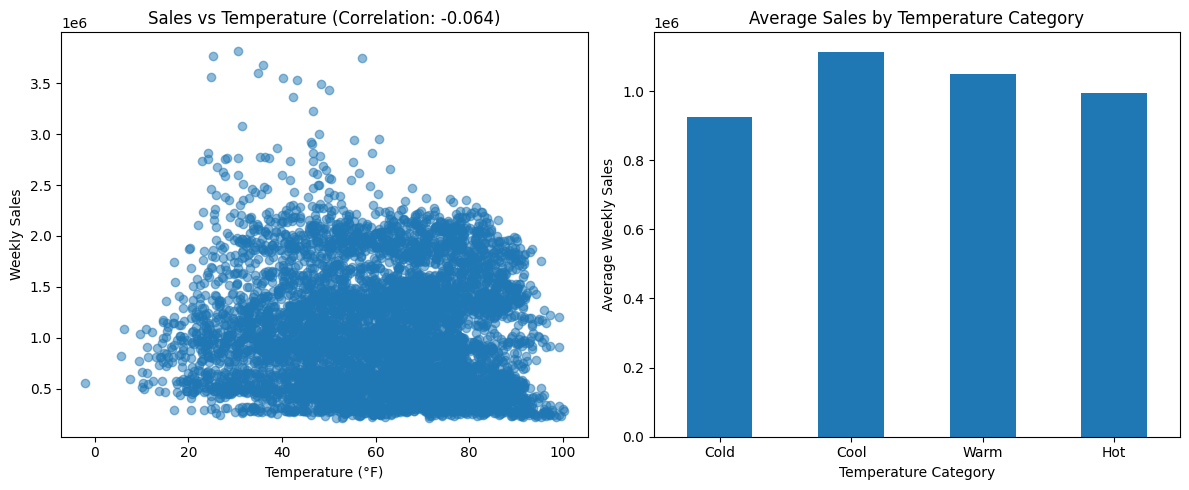

In [15]:
# Temperature correlation
temp_correlation = df['Weekly_Sales'].corr(df['Temperature'])
print(f"Correlation between Weekly Sales and Temperature: {temp_correlation:.4f}")

# Create temperature categories
df['Temp_Category'] = pd.cut(df['Temperature'], bins=4, labels=['Cold', 'Cool', 'Warm', 'Hot'])
temp_sales = df.groupby('Temp_Category')['Weekly_Sales'].mean()

print("\nAverage Sales by Temperature Category:")
for temp, sales in temp_sales.items():
    print(f"{temp}: ${sales:,.2f}")

# Visualize
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['Temperature'], df['Weekly_Sales'], alpha=0.5)
plt.xlabel('Temperature (°F)')
plt.ylabel('Weekly Sales')
plt.title(f'Sales vs Temperature (Correlation: {temp_correlation:.3f})')

plt.subplot(1, 2, 2)
temp_sales.plot(kind='bar')
plt.title('Average Sales by Temperature Category')
plt.xlabel('Temperature Category')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### Question 4: Consumer Price Index Impact

Correlation between Weekly Sales and CPI: -0.0726

Top 5 stores most positively affected by CPI:
Store
38    0.812837
44    0.740150
39    0.428043
41    0.392293
42    0.360859
dtype: float64

Top 5 stores most negatively affected by CPI:
Store
43   -0.285686
30   -0.298188
14   -0.419755
35   -0.424107
36   -0.915095
dtype: float64


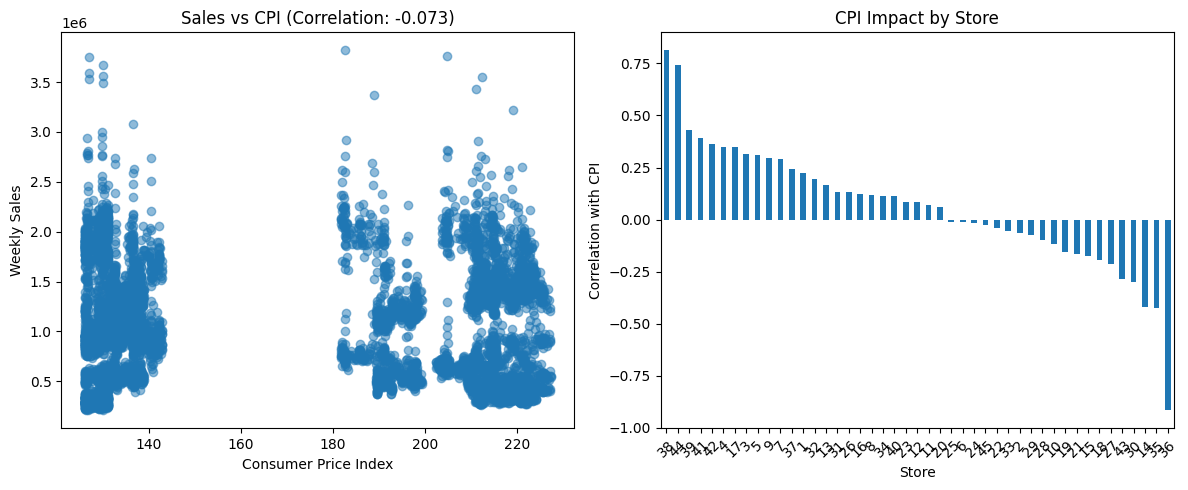

In [16]:
# CPI correlation
cpi_correlation = df['Weekly_Sales'].corr(df['CPI'])
print(f"Correlation between Weekly Sales and CPI: {cpi_correlation:.4f}")

# Store-wise CPI impact
store_cpi_impact = df.groupby('Store').apply(
    lambda x: x['Weekly_Sales'].corr(x['CPI'])
).sort_values(ascending=False)

print("\nTop 5 stores most positively affected by CPI:")
print(store_cpi_impact.head())

print("\nTop 5 stores most negatively affected by CPI:")
print(store_cpi_impact.tail())

# Visualize
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['CPI'], df['Weekly_Sales'], alpha=0.5)
plt.xlabel('Consumer Price Index')
plt.ylabel('Weekly Sales')
plt.title(f'Sales vs CPI (Correlation: {cpi_correlation:.3f})')

plt.subplot(1, 2, 2)
store_cpi_impact.plot(kind='bar')
plt.title('CPI Impact by Store')
plt.xlabel('Store')
plt.ylabel('Correlation with CPI')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Question 5: Store Performance Analysis

Top 10 Performing Stores (by Average Weekly Sales):
        Avg_Sales  Sales_Std   Total_Sales  Week_Count
Store                                                 
20     2107676.87  275900.56  3.013978e+08         143
4      2094712.96  266201.44  2.995440e+08         143
14     2020978.40  317569.95  2.889999e+08         143
13     2003620.31  265507.00  2.865177e+08         143
2      1925751.34  237683.69  2.753824e+08         143
10     1899424.57  302262.06  2.716177e+08         143
27     1775216.20  239930.14  2.538559e+08         143
6      1564728.19  212525.86  2.237561e+08         143
1      1555264.40  155980.77  2.224028e+08         143
39     1450668.13  217466.45  2.074455e+08         143

Worst 5 Performing Stores:
       Avg_Sales  Sales_Std  Total_Sales  Week_Count
Store                                               
38     385731.65   42768.17  55159626.42         143
36     373511.99   60725.17  53412214.97         143
5      318011.81   37737.97  45475688.90        

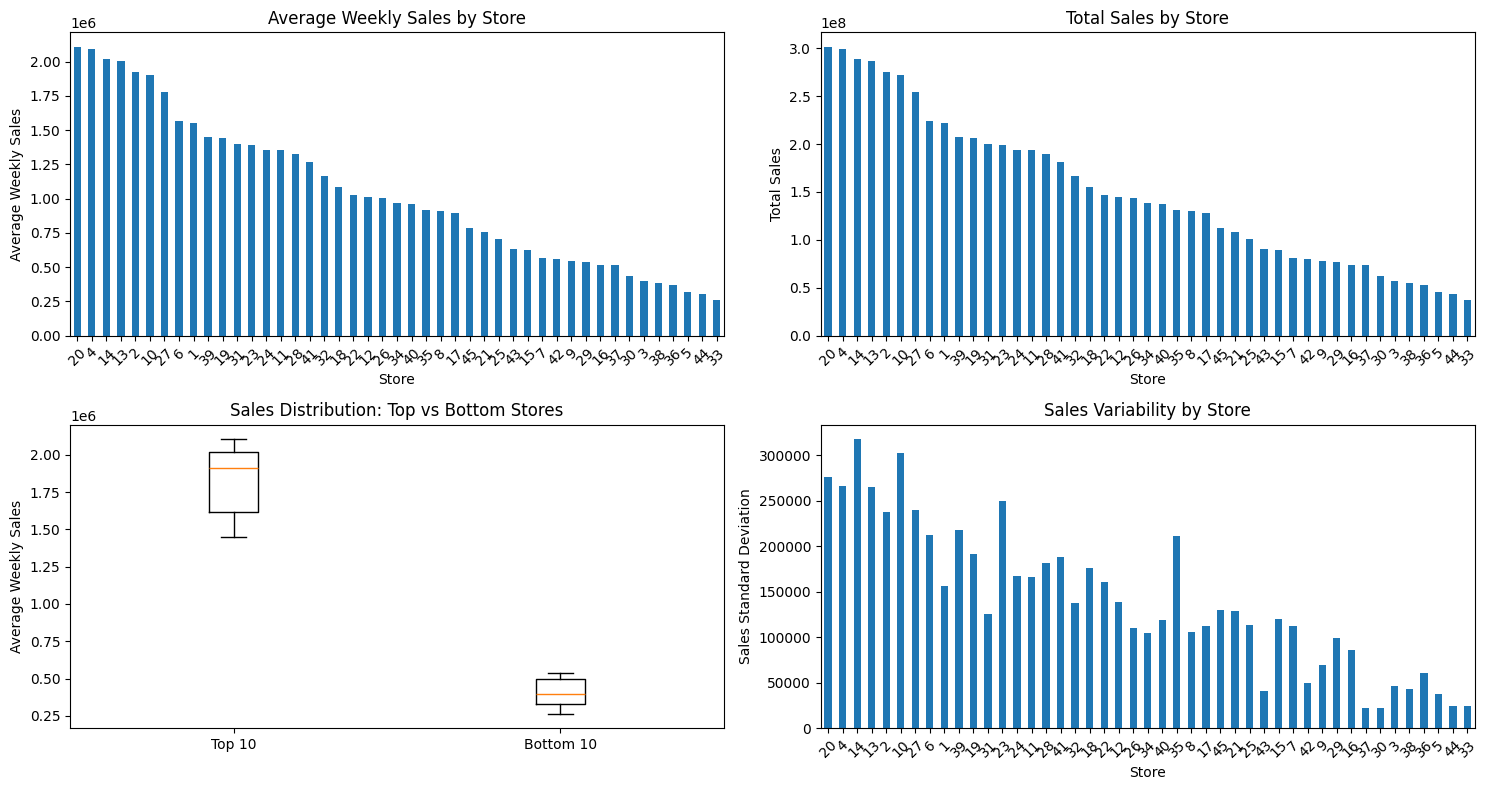

In [17]:
# Calculate store performance metrics
store_performance = df.groupby('Store').agg({
    'Weekly_Sales': ['mean', 'std', 'sum', 'count']
}).round(2)

store_performance.columns = ['Avg_Sales', 'Sales_Std', 'Total_Sales', 'Week_Count']
store_performance = store_performance.sort_values('Avg_Sales', ascending=False)

print("Top 10 Performing Stores (by Average Weekly Sales):")
print(store_performance.head(10))

print("\nWorst 5 Performing Stores:")
print(store_performance.tail(5))

# Calculate performance difference
best_store = store_performance.index[0]
worst_store = store_performance.index[-1]
performance_gap = store_performance.loc[best_store, 'Avg_Sales'] - store_performance.loc[worst_store, 'Avg_Sales']

print(f"\nPerformance Analysis:")
print(f"Best performing store: Store {best_store} (${store_performance.loc[best_store, 'Avg_Sales']:,.2f} avg weekly sales)")
print(f"Worst performing store: Store {worst_store} (${store_performance.loc[worst_store, 'Avg_Sales']:,.2f} avg weekly sales)")
print(f"Performance gap: ${performance_gap:,.2f} ({performance_gap/store_performance.loc[worst_store, 'Avg_Sales']*100:.1f}% difference)")

# Visualize store performance
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
store_performance['Avg_Sales'].plot(kind='bar')
plt.title('Average Weekly Sales by Store')
plt.xlabel('Store')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
store_performance['Total_Sales'].plot(kind='bar')
plt.title('Total Sales by Store')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
# Top 10 vs Bottom 10
top_10 = store_performance.head(10)['Avg_Sales']
bottom_10 = store_performance.tail(10)['Avg_Sales']
plt.boxplot([top_10, bottom_10], labels=['Top 10', 'Bottom 10'])
plt.title('Sales Distribution: Top vs Bottom Stores')
plt.ylabel('Average Weekly Sales')

plt.subplot(2, 2, 4)
store_performance['Sales_Std'].plot(kind='bar')
plt.title('Sales Variability by Store')
plt.xlabel('Store')
plt.ylabel('Sales Standard Deviation')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 5. Correlation Analysis

Correlation Matrix:
              Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price    CPI  \
Weekly_Sales         1.000         0.037       -0.064       0.009 -0.073   
Holiday_Flag         0.037         1.000       -0.155      -0.078 -0.002   
Temperature         -0.064        -0.155        1.000       0.145  0.177   
Fuel_Price           0.009        -0.078        0.145       1.000 -0.171   
CPI                 -0.073        -0.002        0.177      -0.171  1.000   
Unemployment        -0.106         0.011        0.101      -0.035 -0.302   

              Unemployment  
Weekly_Sales        -0.106  
Holiday_Flag         0.011  
Temperature          0.101  
Fuel_Price          -0.035  
CPI                 -0.302  
Unemployment         1.000  


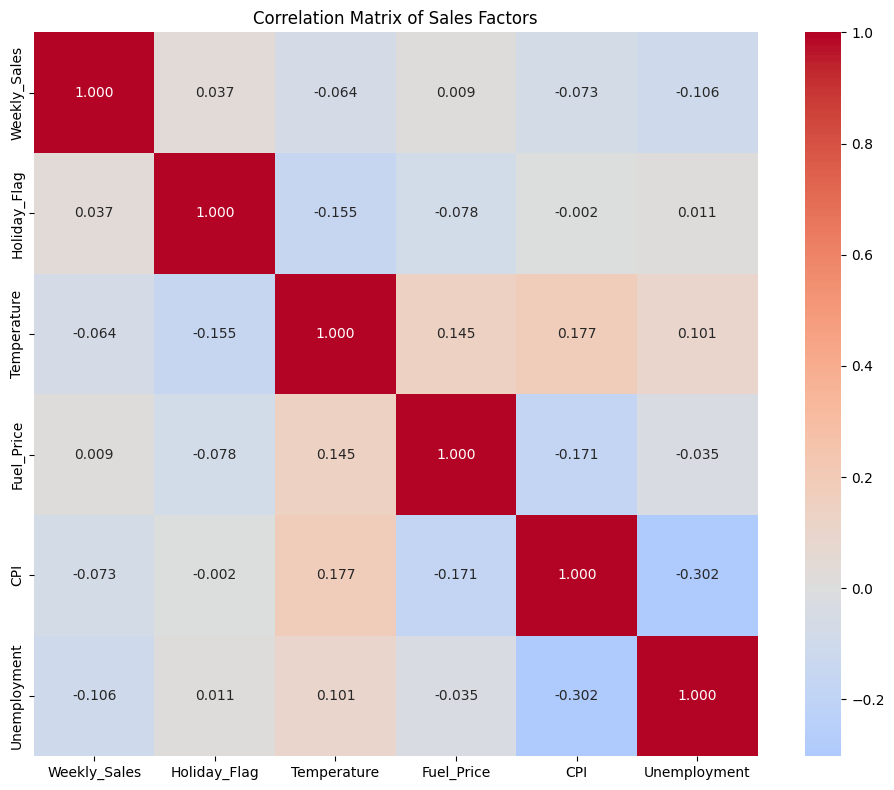


Key Correlation Insights:
Unemployment: -0.106 (weak negative correlation)
CPI: -0.073 (weak negative correlation)
Temperature: -0.064 (weak negative correlation)
Holiday_Flag: 0.037 (weak positive correlation)
Fuel_Price: 0.009 (weak positive correlation)


In [18]:
# Create correlation matrix
numeric_columns = ['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
correlation_matrix = df[numeric_columns].corr()

print("Correlation Matrix:")
print(correlation_matrix.round(3))

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Correlation Matrix of Sales Factors')
plt.tight_layout()
plt.show()

# Key insights
print("\nKey Correlation Insights:")
sales_correlations = correlation_matrix['Weekly_Sales'].drop('Weekly_Sales').sort_values(key=abs, ascending=False)
for factor, corr in sales_correlations.items():
    direction = "positive" if corr > 0 else "negative"
    strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
    print(f"{factor}: {corr:.3f} ({strength} {direction} correlation)")

## 6. Sales Forecasting Models

In [19]:
# Prepare data for modeling
# Select features for prediction
feature_columns = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Quarter']
X = df[feature_columns]
y = df['Weekly_Sales']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 5148
Test set size: 1287


### Model 1: Linear Regression

In [20]:
# Prepare data for modeling
# Select features for prediction
feature_columns = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Quarter']
X = df[feature_columns]
y = df['Weekly_Sales']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values in Month and Quarter with the mode
for col in ['Month', 'Quarter']:
    mode_value = X_train[col].mode()[0]
    X_train[col].fillna(mode_value, inplace=True)
    X_test[col].fillna(mode_value, inplace=True)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test)

# Evaluate model
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print("Linear Regression Results:")
print(f"Mean Squared Error: ${lr_mse:,.2f}")
print(f"Root Mean Squared Error: ${np.sqrt(lr_mse):,.2f}")
print(f"R² Score: {lr_r2:.4f}")

# Feature importance
feature_importance_lr = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Importance (Linear Regression):")
print(feature_importance_lr)

Training set size: 5148
Test set size: 1287
Linear Regression Results:
Mean Squared Error: $274,480,333,580.09
Root Mean Squared Error: $523,908.71
R² Score: 0.1480

Feature Importance (Linear Regression):
        Feature   Coefficient
1  Holiday_Flag  74886.856834
5  Unemployment -24514.901672
0         Store -15078.733311
7       Quarter  10434.108022
3    Fuel_Price  -4630.555178
6         Month  -3329.445873
4           CPI  -2318.473725
2   Temperature   -758.794153


### Model 2: Random Forest

In [21]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)

# Evaluate model
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest Results:")
print(f"Mean Squared Error: ${rf_mse:,.2f}")
print(f"Root Mean Squared Error: ${np.sqrt(rf_mse):,.2f}")
print(f"R² Score: {rf_r2:.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance_rf)

Random Forest Results:
Mean Squared Error: $21,625,252,766.45
Root Mean Squared Error: $147,055.27
R² Score: 0.9329

Feature Importance (Random Forest):
        Feature  Importance
0         Store    0.664784
4           CPI    0.166331
5  Unemployment    0.108121
2   Temperature    0.028226
3    Fuel_Price    0.024570
1  Holiday_Flag    0.003475
6         Month    0.003063
7       Quarter    0.001429


### Model Comparison

Model Comparison:
               Model           RMSE  R² Score
0  Linear Regression  523908.707296  0.147986
1      Random Forest  147055.271128  0.932873

Best performing model: Random Forest


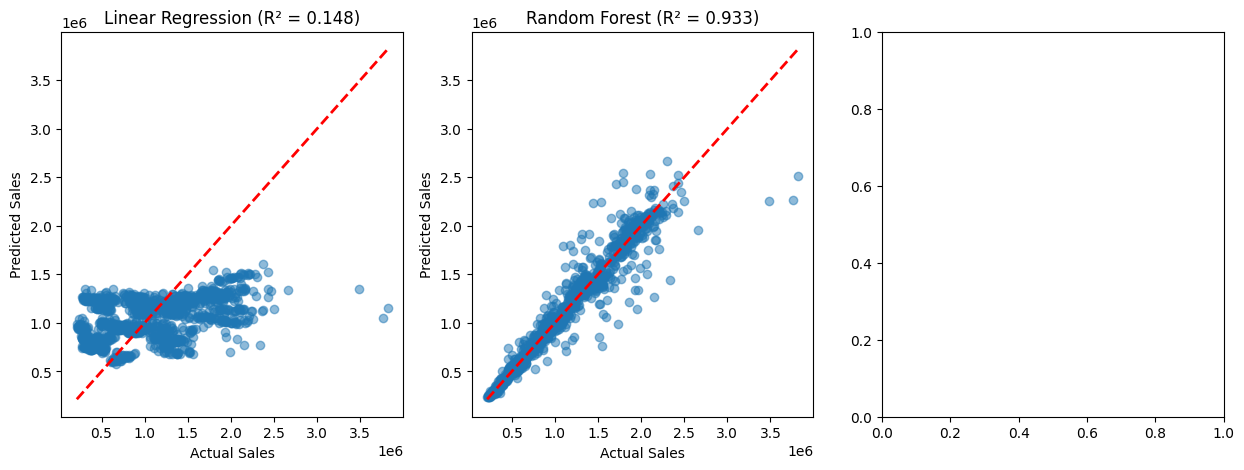

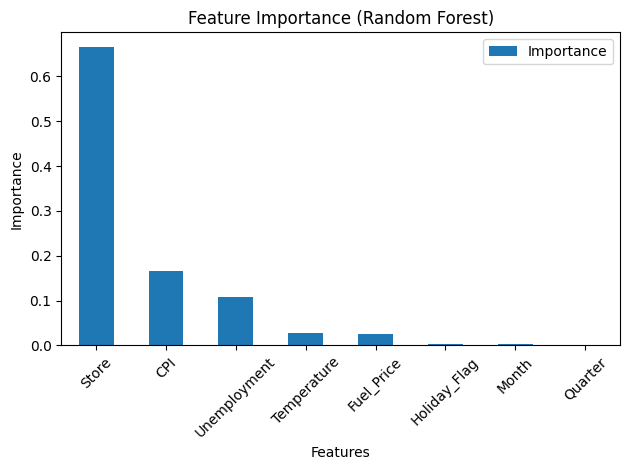

In [22]:
# Compare models
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'RMSE': [np.sqrt(lr_mse), np.sqrt(rf_mse)],
    'R² Score': [lr_r2, rf_r2]
})

print("Model Comparison:")
print(model_comparison)

# Choose best model
best_model_idx = model_comparison['R² Score'].idxmax()
best_model_name = model_comparison.loc[best_model_idx, 'Model']
best_model = rf_model if best_model_name == 'Random Forest' else lr_model

print(f"\nBest performing model: {best_model_name}")

# Visualize predictions vs actual
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, lr_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Linear Regression (R² = {lr_r2:.3f})')

plt.subplot(1, 3, 2)
plt.scatter(y_test, rf_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Random Forest (R² = {rf_r2:.3f})')

plt.subplot(1, 3, 3)
feature_importance_rf.plot(x='Feature', y='Importance', kind='bar')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 7. Store-wise Sales Forecasting (Next 12 Weeks)

In [23]:
# Create future data for next 12 weeks
# Get the latest date and create future dates
last_date = df['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=12, freq='W')

# Get unique stores
stores = df['Store'].unique()
print(f"Generating forecasts for {len(stores)} stores for next 12 weeks")

# Create future data for each store
future_data = []
for store in stores:
    store_data = df[df['Store'] == store]

    # Get recent averages for the store
    recent_data = store_data.tail(4)  # Last 4 weeks

    for date in future_dates:
        future_row = {
            'Store': store,
            'Date': date,
            'Holiday_Flag': 1 if date.month == 12 else 0,  # Assume December has holidays
            'Temperature': recent_data['Temperature'].mean(),
            'Fuel_Price': recent_data['Fuel_Price'].mean(),
            'CPI': recent_data['CPI'].mean(),
            'Unemployment': recent_data['Unemployment'].mean(),
            'Month': date.month,
            'Quarter': (date.month - 1) // 3 + 1
        }
        future_data.append(future_row)

future_df = pd.DataFrame(future_data)
print(f"Created {len(future_df)} future data points")

# Make predictions using the best model
future_features = future_df[feature_columns]
future_predictions = best_model.predict(future_features)
future_df['Predicted_Sales'] = future_predictions

print("\nForecast completed!")
print(f"Future sales predictions range from ${future_predictions.min():,.2f} to ${future_predictions.max():,.2f}")

Generating forecasts for 45 stores for next 12 weeks
Created 540 future data points

Forecast completed!
Future sales predictions range from $267,153.74 to $2,198,970.73


In [24]:
# Analyze forecasts by store
store_forecasts = future_df.groupby('Store')['Predicted_Sales'].agg(['mean', 'sum']).round(2)
store_forecasts.columns = ['Avg_Weekly_Forecast', 'Total_12_Week_Forecast']
store_forecasts = store_forecasts.sort_values('Avg_Weekly_Forecast', ascending=False)

print("Top 10 Stores - 12-Week Sales Forecast:")
print(store_forecasts.head(10))

# Weekly aggregate forecast
weekly_forecast = future_df.groupby('Date')['Predicted_Sales'].sum().reset_index()
weekly_forecast['Week'] = range(1, 13)

print("\nWeekly Total Sales Forecast (All Stores):")
for _, row in weekly_forecast.iterrows():
    print(f"Week {row['Week']} ({row['Date'].strftime('%Y-%m-%d')}): ${row['Predicted_Sales']:,.2f}")

print(f"\nTotal 12-week forecast across all stores: ${weekly_forecast['Predicted_Sales'].sum():,.2f}")

Top 10 Stores - 12-Week Sales Forecast:
       Avg_Weekly_Forecast  Total_12_Week_Forecast
Store                                             
4               2175371.27             26104455.19
20              2143565.41             25722784.92
13              2049562.69             24594752.32
2               1930177.97             23162135.69
10              1785384.18             21424610.15
27              1725294.32             20703531.79
14              1675027.48             20100329.79
1               1620469.81             19445637.69
39              1561166.12             18733993.50
6               1492028.02             17904336.27

Weekly Total Sales Forecast (All Stores):
Week 1 (2012-12-23): $48,217,505.74
Week 2 (2012-12-30): $48,217,505.74
Week 3 (2013-01-06): $46,383,165.68
Week 4 (2013-01-13): $46,383,165.68
Week 5 (2013-01-20): $46,383,165.68
Week 6 (2013-01-27): $46,383,165.68
Week 7 (2013-02-03): $46,503,286.73
Week 8 (2013-02-10): $46,503,286.73
Week 9 (2013-02-1

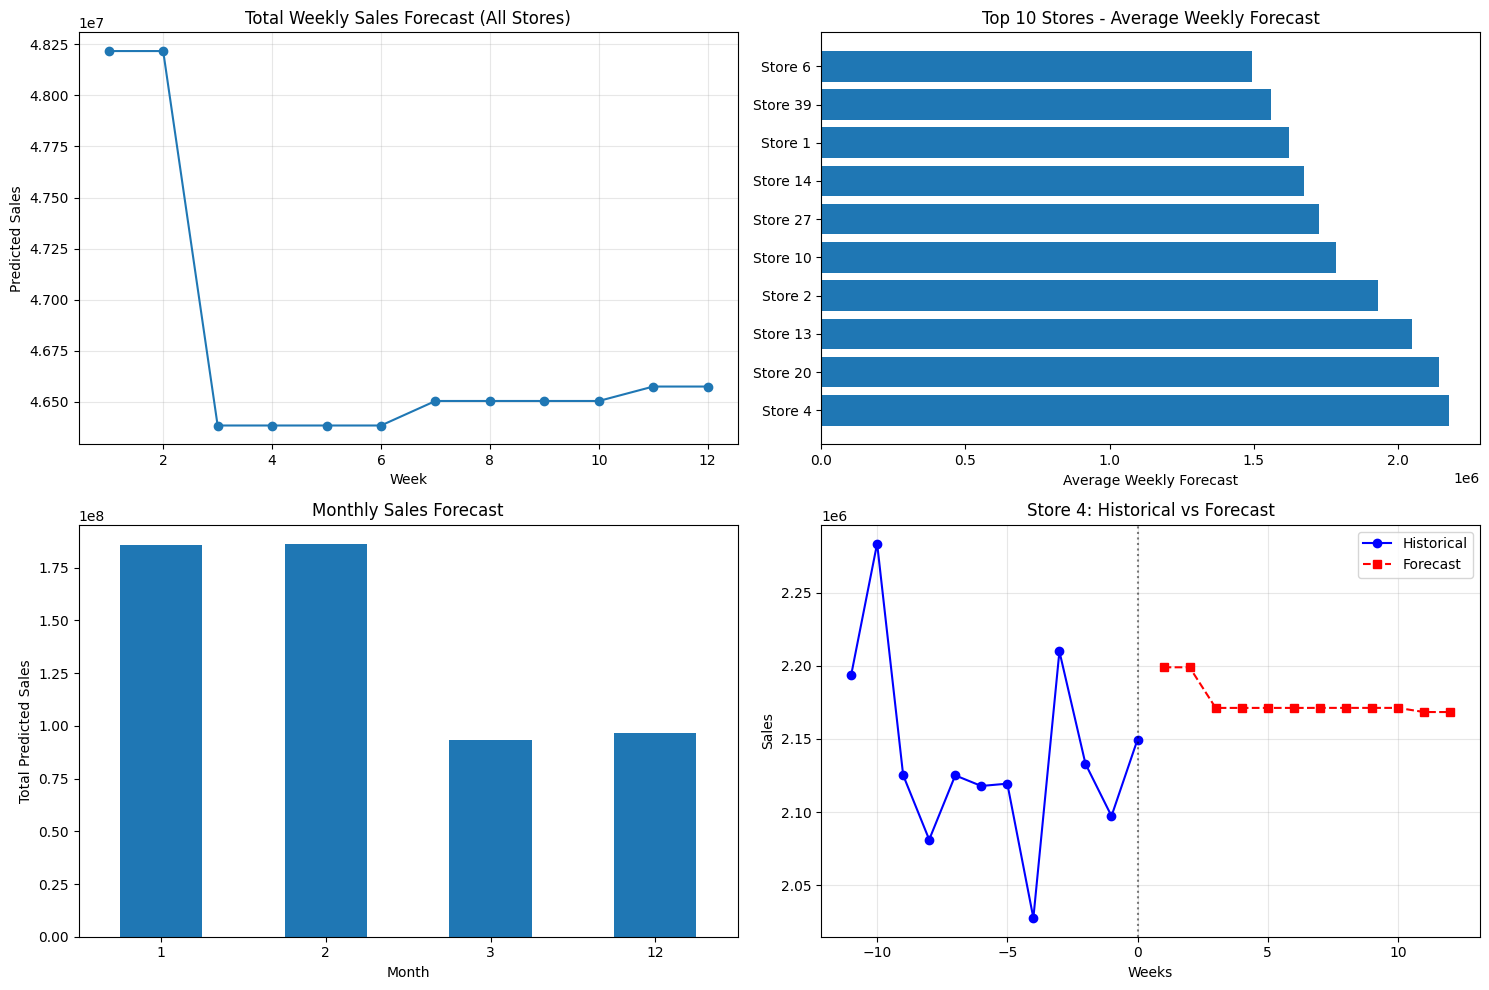

In [25]:
# Visualize forecasts
plt.figure(figsize=(15, 10))

# Weekly forecast trend
plt.subplot(2, 2, 1)
plt.plot(weekly_forecast['Week'], weekly_forecast['Predicted_Sales'], marker='o')
plt.title('Total Weekly Sales Forecast (All Stores)')
plt.xlabel('Week')
plt.ylabel('Predicted Sales')
plt.grid(True, alpha=0.3)

# Store-wise average forecast
plt.subplot(2, 2, 2)
top_stores = store_forecasts.head(10)
plt.barh(range(len(top_stores)), top_stores['Avg_Weekly_Forecast'])
plt.yticks(range(len(top_stores)), [f'Store {idx}' for idx in top_stores.index])
plt.xlabel('Average Weekly Forecast')
plt.title('Top 10 Stores - Average Weekly Forecast')

# Monthly comparison (if forecast spans multiple months)
plt.subplot(2, 2, 3)
monthly_forecast = future_df.groupby(future_df['Date'].dt.month)['Predicted_Sales'].sum()
monthly_forecast.plot(kind='bar')
plt.title('Monthly Sales Forecast')
plt.xlabel('Month')
plt.ylabel('Total Predicted Sales')
plt.xticks(rotation=0)

# Historical vs Forecast comparison for top store
plt.subplot(2, 2, 4)
top_store = store_forecasts.index[0]
historical = df[df['Store'] == top_store]['Weekly_Sales'].tail(12)
forecast = future_df[future_df['Store'] == top_store]['Predicted_Sales']

weeks = list(range(-11, 1)) + list(range(1, 13))
all_sales = list(historical) + list(forecast)

plt.plot(weeks[:12], all_sales[:12], 'b-', label='Historical', marker='o')
plt.plot(weeks[12:], all_sales[12:], 'r--', label='Forecast', marker='s')
plt.axvline(x=0, color='k', linestyle=':', alpha=0.5)
plt.title(f'Store {top_store}: Historical vs Forecast')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Key Insights and Recommendations

In [28]:
# ----------------------------------------
# Summary Insights
# ----------------------------------------

# 1. Unemployment impact
unemployment_corr = df['Weekly_Sales'].corr(df['Unemployment'])
most_affected_store = (
    df.groupby('Store')
      .apply(lambda x: x['Weekly_Sales'].corr(x['Unemployment']))
      .idxmin()
)

# 2. Seasonal trends
peak_month = df.groupby('Month')['Weekly_Sales'].mean().idxmax()
holiday_boost = (
    df[df['Holiday_Flag'] == 1]['Weekly_Sales'].mean() /
    df[df['Holiday_Flag'] == 0]['Weekly_Sales'].mean()
)

# 3. Temperature impact
temp_corr = df['Weekly_Sales'].corr(df['Temperature'])

# 4. CPI impact
cpi_corr = df['Weekly_Sales'].corr(df['CPI'])

# 5. Store performance
best_store = store_performance.index[0]
worst_store = store_performance.index[-1]
performance_gap = (
    store_performance.loc[best_store, 'Avg_Sales'] -
    store_performance.loc[worst_store, 'Avg_Sales']
)

# 6. Model performance
best_r2 = rf_r2 if best_model_name == 'Random Forest' else lr_r2
total_forecast_12_weeks = weekly_forecast['Predicted_Sales'].sum()

summary_insights = {
    "Unemployment_Correlation": unemployment_corr,
    "Most_Affected_Store": best_store,
    "Peak_Month": peak_month,
    "Holiday_Sales_Boost_%": (holiday_boost - 1) * 100,
    "Temperature_Correlation": temp_corr,
    "CPI_Correlation": cpi_corr,
    "Best_Store": best_store,
    "Worst_Store": worst_store,
    "Performance_Gap": performance_gap,
    "Best_Model": best_model_name,
    "Best_Model_R2": best_r2,
    "Forecast_Next_12_Weeks": total_forecast_12_weeks
}

summary_insights


{'Unemployment_Correlation': np.float64(-0.10617608965795418),
 'Most_Affected_Store': np.int64(20),
 'Peak_Month': np.float64(10.0),
 'Holiday_Sales_Boost_%': np.float64(7.839713033050177),
 'Temperature_Correlation': np.float64(-0.06381001317946956),
 'CPI_Correlation': np.float64(-0.07263416204017628),
 'Best_Store': np.int64(20),
 'Worst_Store': np.int64(33),
 'Performance_Gap': np.float64(1847815.1800000002),
 'Best_Model': 'Random Forest',
 'Best_Model_R2': 0.9328730518189869,
 'Forecast_Next_12_Weeks': np.float64(561128831.1564001)}

## 9. Export Results

In [29]:
# Save forecast results to CSV
forecast_summary = future_df.pivot(index='Date', columns='Store', values='Predicted_Sales')
forecast_summary.to_csv('walmart_sales_forecast_12_weeks.csv')

# Save store performance analysis
store_performance.to_csv('walmart_store_performance_analysis.csv')

# Save weekly forecast summary
weekly_forecast.to_csv('walmart_weekly_forecast_summary.csv', index=False)

print("Results exported successfully!")
print("Files created:")
print("• walmart_sales_forecast_12_weeks.csv - Store-wise weekly forecasts")
print("• walmart_store_performance_analysis.csv - Store performance metrics")
print("• walmart_weekly_forecast_summary.csv - Weekly total forecasts")

print("\nANALYSIS COMPLETE!")
print("This comprehensive analysis provides insights into sales patterns,")
print("store performance, and 12-week sales forecasts to help with")
print("inventory management and business planning.")

Results exported successfully!
Files created:
• walmart_sales_forecast_12_weeks.csv - Store-wise weekly forecasts
• walmart_store_performance_analysis.csv - Store performance metrics
• walmart_weekly_forecast_summary.csv - Weekly total forecasts

ANALYSIS COMPLETE!
This comprehensive analysis provides insights into sales patterns,
store performance, and 12-week sales forecasts to help with
inventory management and business planning.
